In [1]:
# ===== Imports =====

# Core
import os
import sys
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (nice plots)
import seaborn as sns

# Scikit-learn: data prep
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn: metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# Imbalanced-learn (optional)
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

# XGBoost (optional)
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

In [2]:
# ===== Config =====

# Paths
PROJECT_ROOT = os.getcwd()  # assumes notebook opened from project folder
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "/Users/jobinjohn/stroke prediction model/healthcare-dataset-stroke.csv")
FIG_DIR = os.path.join(PROJECT_ROOT, "reports", "figures")
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Constants
RANDOM_STATE = 42
TARGET_COL = "stroke"   # change if your target column has a different name
TEST_SIZE = 0.20

# Diagnostics
print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)
print("Figures ->", FIG_DIR)
print("Models  ->", MODEL_DIR)
print("imblearn available:", IMBLEARN_AVAILABLE, "| xgboost available:", XGB_AVAILABLE)

Project root: /Users/jobinjohn/stroke prediction model
Data path: /Users/jobinjohn/stroke prediction model/healthcare-dataset-stroke.csv
Figures -> /Users/jobinjohn/stroke prediction model/reports/figures
Models  -> /Users/jobinjohn/stroke prediction model/models
imblearn available: True | xgboost available: True


In [3]:
# ===== Load Data =====
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(5)

(2500, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,54.6,0,0,Yes,Self-employed,Rural,128.2,29.4,never smoked,0
1,Male,34.4,0,0,No,Self-employed,Urban,68.6,32.1,never smoked,0
2,Female,61.3,0,0,Yes,Govt_job,Rural,83.7,25.1,smokes,0
3,Female,64.1,0,0,No,Private,Rural,103.9,33.0,formerly smoked,0
4,Male,20.7,0,0,Yes,Self-employed,Urban,88.2,17.2,smokes,0


Target counts:
 stroke
0    2246
1     254
Name: count, dtype: int64

Positive rate: 0.1016

Missing values:
 Series([], dtype: int64)


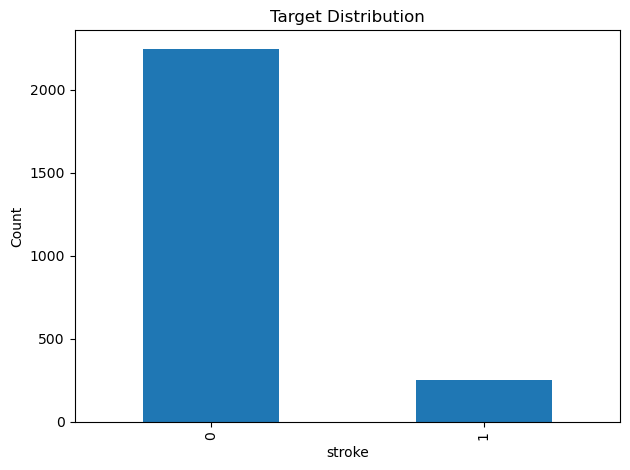

In [4]:
# EDA: Target distribution & missingness
assert TARGET_COL in df.columns, f"Target '{TARGET_COL}' not found in columns."

# Target distribution
target_counts = df[TARGET_COL].value_counts(dropna=False).sort_index()
print("Target counts:\n", target_counts)
print("\nPositive rate:", round(df[TARGET_COL].mean(), 4))

# Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values:\n", missing[missing > 0])

# Simple bar for target distribution
plt.figure()
target_counts.plot(kind="bar")
plt.title("Target Distribution")
plt.xlabel(TARGET_COL)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

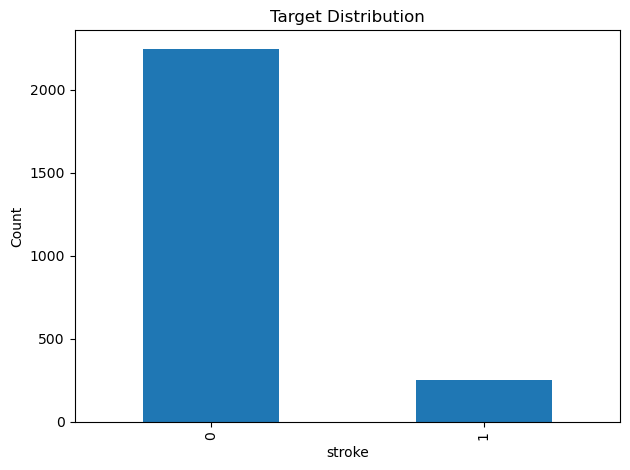

Saved: /Users/jobinjohn/stroke prediction model/reports/figures/target_distribution.png


In [20]:
# ===== Target distribution =====
plt.figure()
target_counts.plot(kind="bar")
plt.title("Target Distribution")
plt.xlabel(TARGET_COL)
plt.ylabel("Count")
plt.tight_layout()

# Save to figures folder
out = os.path.join(FIG_DIR, "target_distribution.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

Numeric columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


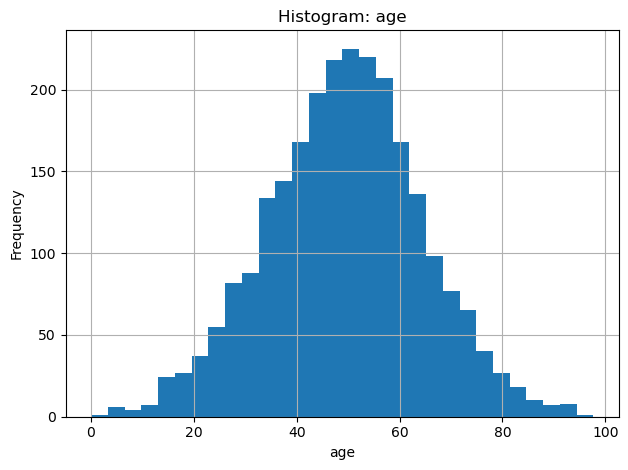

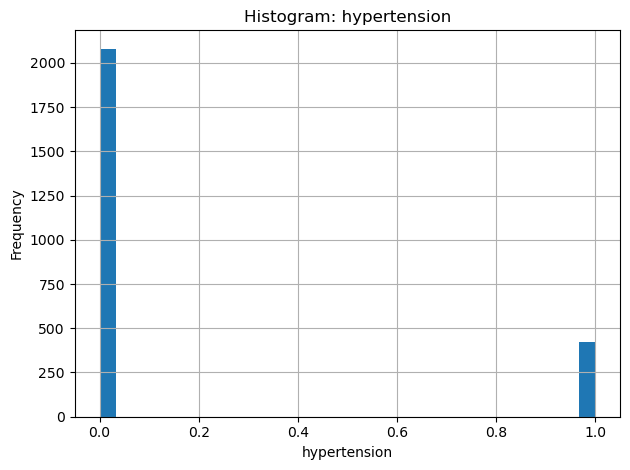

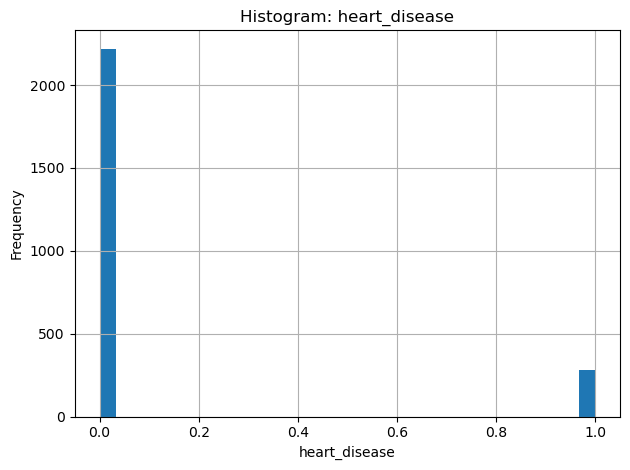

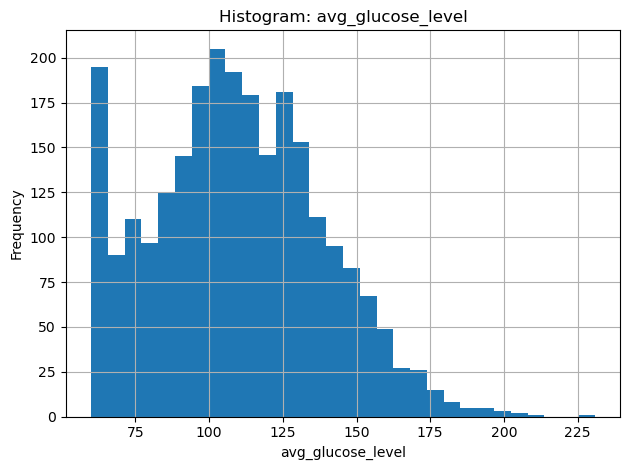

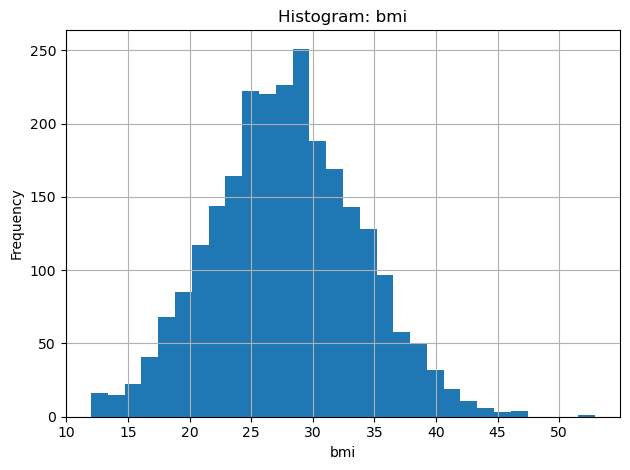

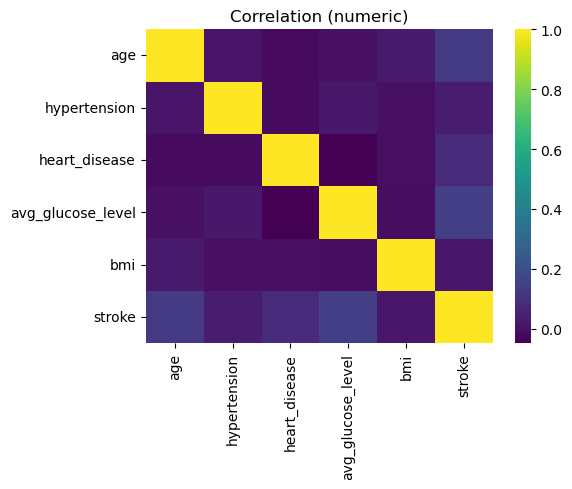

In [5]:
# ===== EDA: Numeric & categorical overview =====
num_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET_COL, errors="ignore").tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Histograms for a few numeric columns
sample_nums = num_cols[:6]
for col in sample_nums:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# (Optional) correlation heatmap
if len(num_cols) > 1:
    corr = df[num_cols + [TARGET_COL]].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=False, cmap="viridis")
    plt.title("Correlation (numeric)")
    plt.tight_layout()
    plt.show()

In [6]:
# ===== Train/Test Split =====
y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (2000, 10)  Test size: (500, 10)


In [7]:
# ===== Preprocessing pipeline =====
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Numeric features:", len(numeric_features), "| Categorical features:", len(categorical_features))

Numeric features: 5 | Categorical features: 5


In [8]:
# ===== Define models =====
models = {
    "logreg": LogisticRegression(
        max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE
    ),
    "rf": RandomForestClassifier(
        n_estimators=400, random_state=RANDOM_STATE,
        n_jobs=-1, class_weight="balanced_subsample"
    )
}

# Optional: XGBoost
if XGB_AVAILABLE:
    models["xgb"] = XGBClassifier(
        max_depth=4, n_estimators=400, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=RANDOM_STATE, eval_metric="logloss"
    )

# Optional: Logistic Regression + SMOTE
if IMBLEARN_AVAILABLE:
    models["smote_logreg"] = ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])

print("Models ready:", list(models.keys()))

Models ready: ['logreg', 'rf', 'xgb', 'smote_logreg']


In [9]:
# ===== Utilities: fit, evaluate, and plot =====
from typing import Dict
from sklearn.base import BaseEstimator

def fit_pipeline(model: BaseEstimator):
    """Wrap preprocessor+model in a single sklearn Pipeline."""
    return Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

def evaluate(pipe: Pipeline, X_test, y_test, name: str) -> Dict:
    """Compute metrics + plots; save figures to FIG_DIR."""
    out = {}

    # Probabilities (if available)
    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") else None
    y_pred = (y_prob >= 0.5).astype(int) if y_prob is not None else pipe.predict(X_test)

    # Metrics
    out["cm"] = confusion_matrix(y_test, y_pred)
    out["report"] = classification_report(y_test, y_pred, digits=4, output_dict=True)

    if y_prob is not None:
        out["roc_auc"] = roc_auc_score(y_test, y_prob)
        out["pr_auc"]  = average_precision_score(y_test, y_prob)

        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={out['roc_auc']:.3f})")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(f"ROC — {name}")
        plt.legend(loc="lower right"); plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"roc_curve_{name}.png"), dpi=200)
        plt.show()

        # PR
        prec, rec, _ = precision_recall_curve(y_test, y_prob)
        plt.figure()
        plt.plot(rec, prec, label=f"{name} (AP={out['pr_auc']:.3f})")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — {name}")
        plt.legend(loc="lower left"); plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"pr_curve_{name}.png"), dpi=200)
        plt.show()

    # Confusion matrix
    cm = out["cm"]
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix — {name}")
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ["No Stroke", "Stroke"]); plt.yticks(ticks, ["No Stroke", "Stroke"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"confusion_matrix_{name}.png"), dpi=200)
    plt.show()

    return out

def summarize(results: Dict[str, Dict]) -> pd.DataFrame:
    rows = []
    for name, res in results.items():
        rep = res["report"].get("1", {})  # positive class row
        rows.append({
            "model": name,
            "roc_auc": res.get("roc_auc", np.nan),
            "pr_auc":  res.get("pr_auc",  np.nan),
            "precision_pos": rep.get("precision", np.nan),
            "recall_pos":    rep.get("recall",    np.nan),
            "f1_pos":        rep.get("f1-score",  np.nan),
        })
    return pd.DataFrame(rows).sort_values(by=["pr_auc","roc_auc"], ascending=[False, False]).reset_index(drop=True)

Models to train: ['logreg', 'rf', 'xgb', 'smote_logreg']

=== Training: logreg ===


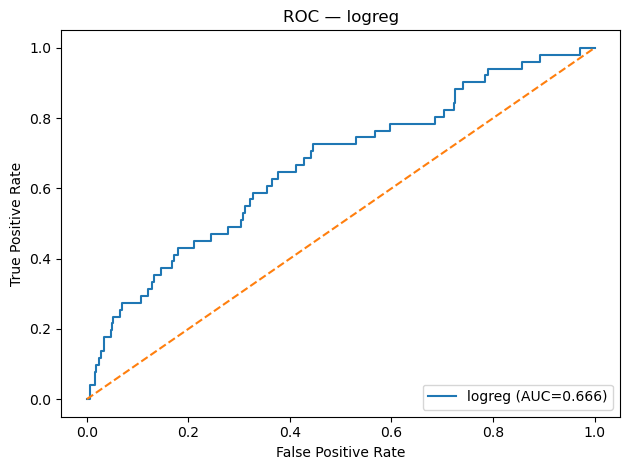

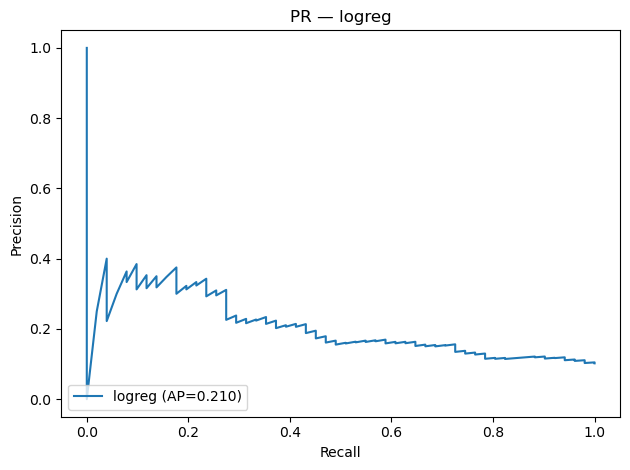

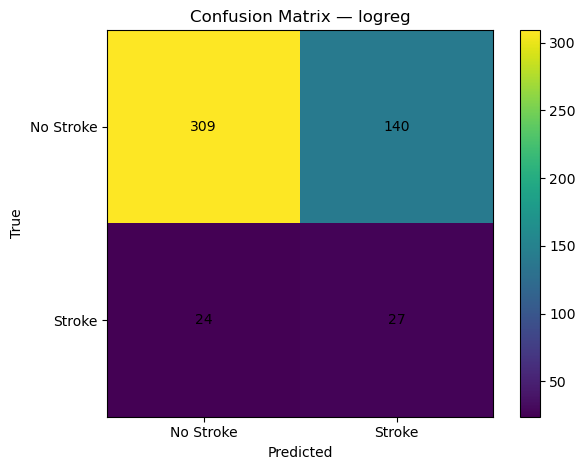

...done: logreg

=== Training: rf ===


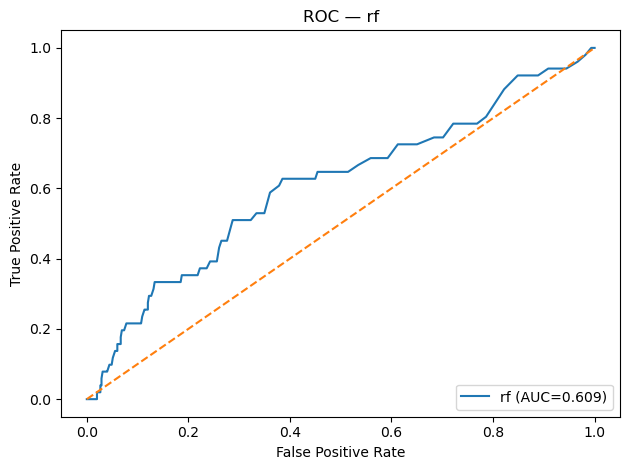

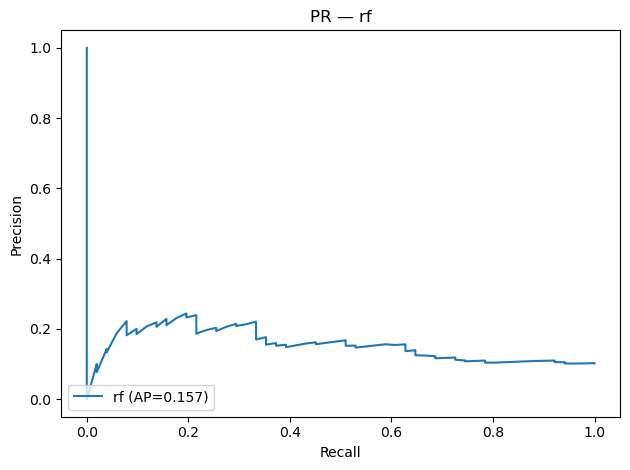

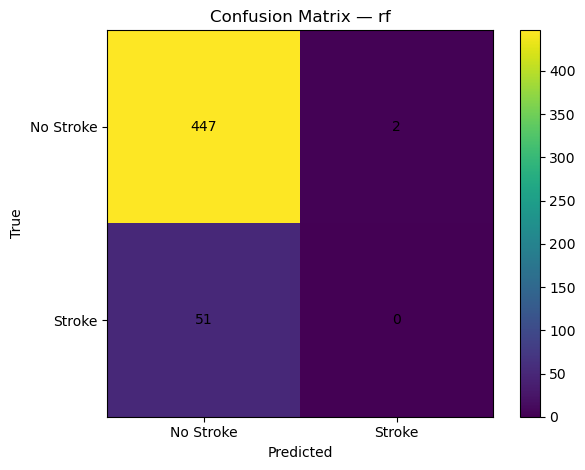

...done: rf

=== Training: xgb ===


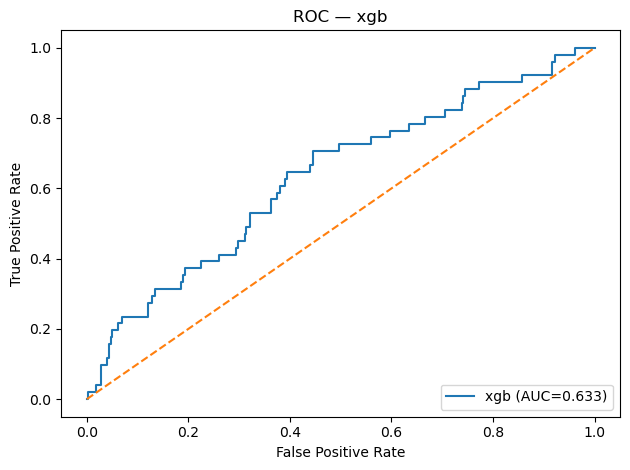

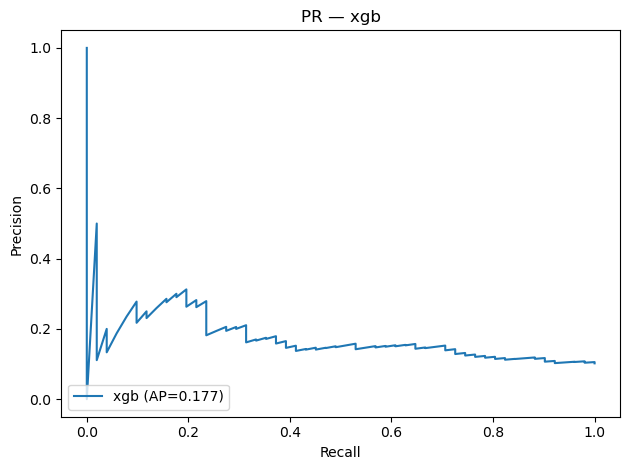

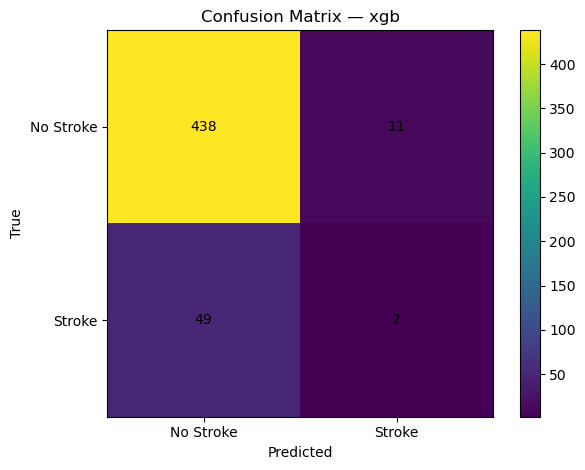

...done: xgb

=== Training: smote_logreg ===


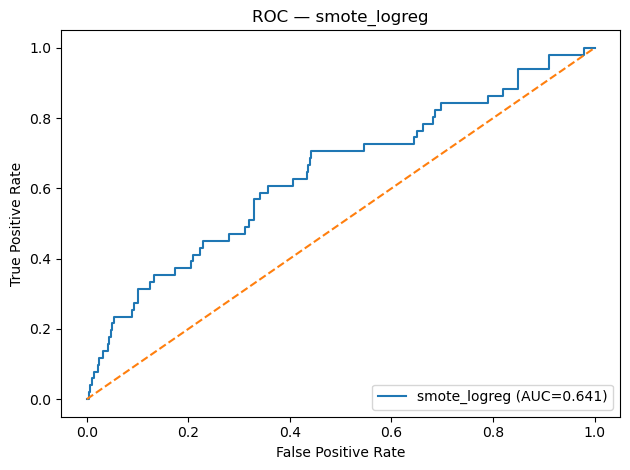

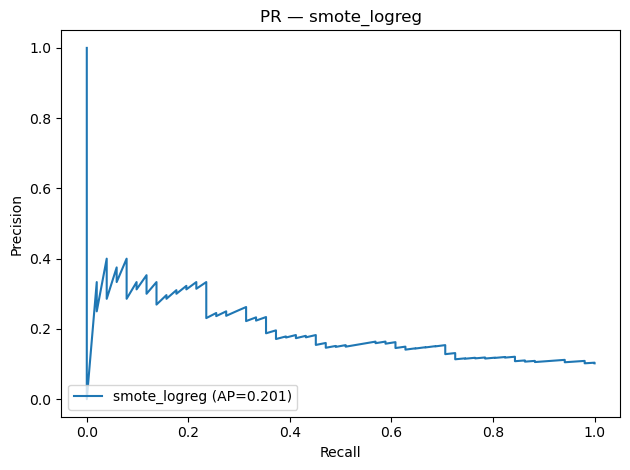

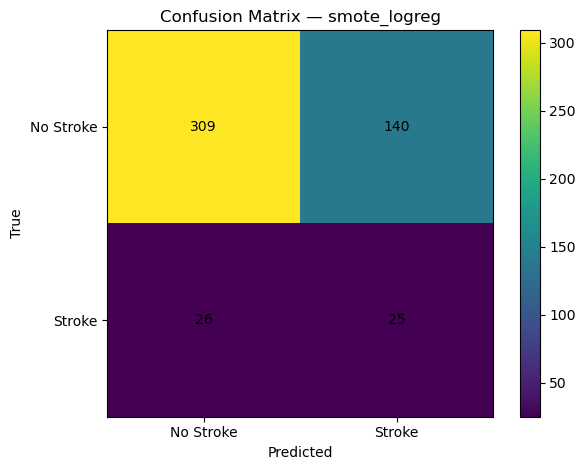

...done: smote_logreg

=== Summary ===


,model,roc_auc,pr_auc,precision_pos,recall_pos,f1_pos
0,logreg,0.665837,0.209590,0.161677,0.529412,0.247706
1,smote_logreg,0.641076,0.200881,0.151515,0.490196,0.231481
2,xgb,0.633259,0.177423,0.153846,0.039216,0.062500
3,rf,0.608629,0.156830,0.000000,0.000000,0.000000



Saved figures to: /Users/jobinjohn/stroke prediction model/reports/figures


In [10]:
# ===== Train all models and collect results (verbose) =====
import traceback
from IPython.display import display

assert 'models' in globals() and isinstance(models, dict) and len(models) > 0, "Models dict is empty. Run Cell 7."

results = {}
print("Models to train:", list(models.keys()))

for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    try:
        if name == "smote_logreg":
            # smote_logreg is already a pipeline
            model.fit(X_train, y_train)
            res = evaluate(model, X_test, y_test, name)
            res["pipeline"] = model
            results[name] = res
        else:
            pipe = fit_pipeline(model)
            pipe.fit(X_train, y_train)
            res = evaluate(pipe, X_test, y_test, name)
            res["pipeline"] = pipe
            results[name] = res
        print(f"...done: {name}")
    except Exception as e:
        print(f"[ERROR] while training {name}: {e}")
        traceback.print_exc()

print("\n=== Summary ===")
summary = summarize(results)
display(summary)           # ensure it shows in notebooks
print("\nSaved figures to:", FIG_DIR)

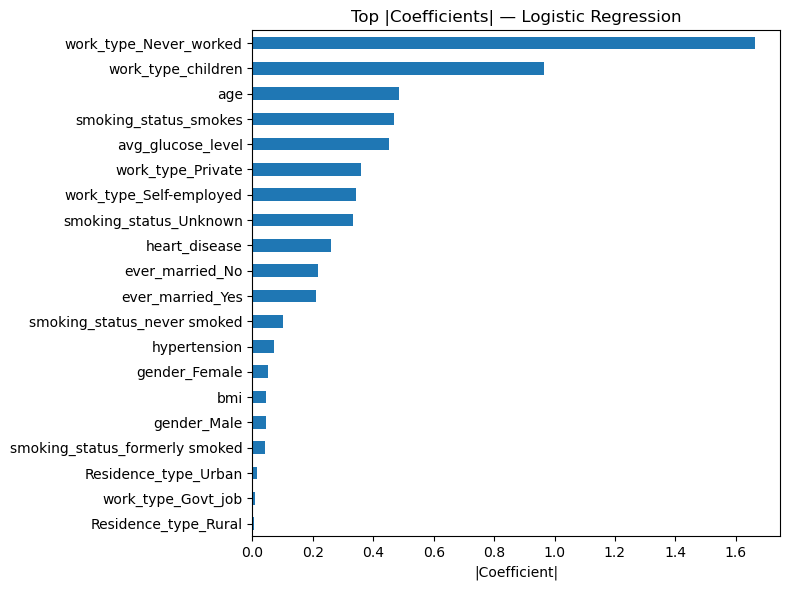

Saved: /Users/jobinjohn/stroke prediction model/reports/figures/feature_importance_logreg.png


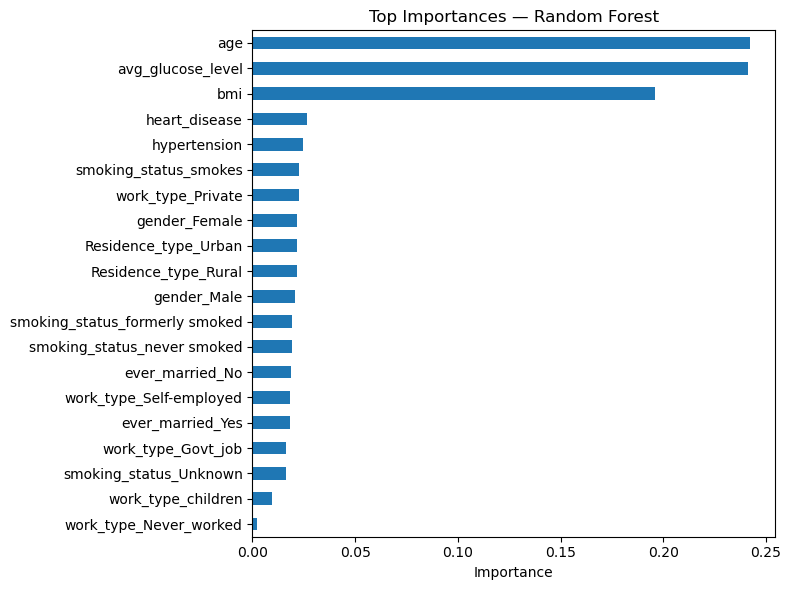

Saved: /Users/jobinjohn/stroke prediction model/reports/figures/feature_importance_rf.png


In [11]:
# ----- Interpretability -----
def plot_logreg_coeffs(pipe, title="Top |Coefficients| — Logistic Regression", top_k=20, fname="feature_importance_logreg.png"):
    from sklearn.linear_model import LogisticRegression
    if not isinstance(pipe.named_steps["model"], LogisticRegression):
        print("Skip: not a LogisticRegression pipeline."); return
    pre = pipe.named_steps["preprocess"]
    num_names = pre.transformers_[0][2] if len(pre.transformers_) > 0 else []
    ohe = pre.named_transformers_["cat"].named_steps["ohe"] if "cat" in pre.named_transformers_ else None
    cat_names = list(ohe.get_feature_names_out(pre.transformers_[1][2])) if ohe is not None else []
    feat_names = list(num_names) + cat_names
    coefs = pipe.named_steps["model"].coef_[0]
    s = pd.Series(np.abs(coefs), index=feat_names).sort_values(ascending=False).head(top_k).sort_values()
    plt.figure(figsize=(8,6)); s.plot(kind="barh")
    plt.title(title); plt.xlabel("|Coefficient|"); plt.tight_layout()
    out = os.path.join(FIG_DIR, fname); plt.savefig(out, dpi=200); plt.show(); print("Saved:", out)

def plot_rf_importance(pipe, title="Top Importances — Random Forest", top_k=20, fname="feature_importance_rf.png"):
    from sklearn.ensemble import RandomForestClassifier
    if not isinstance(pipe.named_steps["model"], RandomForestClassifier):
        print("Skip: not a RandomForest pipeline."); return
    pre = pipe.named_steps["preprocess"]
    num_names = pre.transformers_[0][2] if len(pre.transformers_) > 0 else []
    ohe = pre.named_transformers_["cat"].named_steps["ohe"] if "cat" in pre.named_transformers_ else None
    cat_names = list(ohe.get_feature_names_out(pre.transformers_[1][2])) if ohe is not None else []
    feat_names = list(num_names) + cat_names
    imp = pd.Series(pipe.named_steps["model"].feature_importances_, index=feat_names).sort_values(ascending=False).head(top_k).sort_values()
    plt.figure(figsize=(8,6)); imp.plot(kind="barh")
    plt.title(title); plt.xlabel("Importance"); plt.tight_layout()
    out = os.path.join(FIG_DIR, fname); plt.savefig(out, dpi=200); plt.show(); print("Saved:", out)

# Generate plots for applicable models you just trained in Cell 9
if "logreg" in results: plot_logreg_coeffs(results["logreg"]["pipeline"])
if "rf" in results:     plot_rf_importance(results["rf"]["pipeline"])

In [12]:
def pick_best(df: pd.DataFrame) -> str:
    d = df.copy()
    d["pr_auc"]  = d["pr_auc"].fillna(-1)
    d["roc_auc"] = d["roc_auc"].fillna(-1)
    d = d.sort_values(by=["pr_auc","roc_auc"], ascending=[False, False])
    return d.iloc[0]["model"]

best_name = pick_best(summary)
best_pipe = results[best_name]["pipeline"]

model_path = os.path.join(MODEL_DIR, f"stroke_model__{best_name}.joblib")
joblib.dump(best_pipe, model_path)
print(f"Saved best model → {model_path}")

summary  # show final comparison table again

Saved best model → /Users/jobinjohn/stroke prediction model/models/stroke_model__logreg.joblib


,model,roc_auc,pr_auc,precision_pos,recall_pos,f1_pos
0,logreg,0.665837,0.209590,0.161677,0.529412,0.247706
1,smote_logreg,0.641076,0.200881,0.151515,0.490196,0.231481
2,xgb,0.633259,0.177423,0.153846,0.039216,0.062500
3,rf,0.608629,0.156830,0.000000,0.000000,0.000000


In [13]:
# Load the saved pipeline and predict on 5 holdout rows
pipe = joblib.load(model_path)
sample = X_test.sample(5, random_state=RANDOM_STATE)
pred  = pipe.predict(sample)
prob  = pipe.predict_proba(sample)[:,1] if hasattr(pipe, "predict_proba") else np.nan

display(pd.DataFrame({"pred": pred, "prob": prob}).reset_index(drop=True))
sample  # also display the covariates for context

,pred,prob
0,0,0.319250
1,0,0.424618
2,1,0.587261
3,0,0.384140
4,1,0.563536


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
2150,Female,49.0,0,0,Yes,Self-employed,Urban,98.9,27.9,Unknown
303,Male,45.1,0,0,Yes,Private,Urban,110.8,34.5,never smoked
2273,Male,63.6,1,0,Yes,Govt_job,Urban,133.4,19.6,never smoked
923,Male,41.4,0,0,No,Private,Rural,128.2,39.2,formerly smoked
2063,Male,55.7,0,0,Yes,Private,Urban,130.9,22.1,never smoked


In [15]:
# Tune threshold to meet a target precision or maximize F1 for the positive class
best = results[best_name]
pipe = best["pipeline"]

y_prob = pipe.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_prob)

# Example A: choose the smallest threshold that achieves >= 0.80 precision
target_precision = 0.80
mask = prec[:-1] >= target_precision  # last prec aligns with threshold=None
if mask.any():
    t_star = thr[mask.argmax()]  # first threshold reaching target precision
else:
    t_star = 0.5  # fallback
print(f"Chosen threshold for >={target_precision:.2f} precision:", round(float(t_star), 4))

# Example B: maximize F1
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
i_star = np.nanargmax(f1[:-1])  # align with thresholds
t_f1 = thr[i_star]
print("Threshold maximizing F1:", round(float(t_f1), 4), "F1:", round(float(f1[i_star]), 4))

# Re-score confusion matrix at the chosen threshold (pick t_star or t_f1)
use_t = float(t_f1)
y_pred_t = (y_prob >= use_t).astype(int)
cm_t = confusion_matrix(y_test, y_pred_t)
print("Confusion @ tuned threshold:\n", cm_t)

Chosen threshold for >=0.80 precision: 0.5
Threshold maximizing F1: 0.6838 F1: 0.2917
Confusion @ tuned threshold:
 [[418  31]
 [ 37  14]]


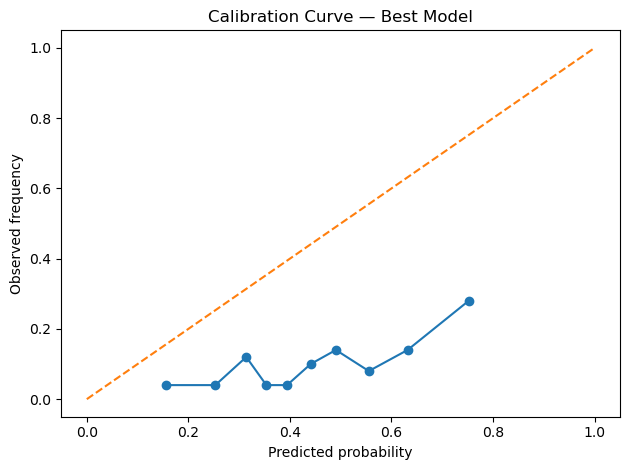

Brier score (lower is better): 0.2119


In [16]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")
plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration Curve — Best Model")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, f"calibration_{best_name}.png"), dpi=200)
plt.show()

print("Brier score (lower is better):", round(brier_score_loss(y_test, y_prob), 4))

In [18]:
![Target Distribution](figures/target_distribution.png)

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `[Target Distribution](figures/target_distribution.png)'
